#  Simulated Daily Activity Dataset from Smartwatch Sensors

This synthetic dataset simulates daily motion signals collected from **1000 individuals** wearing a smartwatch over a **30-day** period.

###  How it was generated:
- Each individual is randomly assigned to one of **6 activity profiles**:
  - 0 = Sedentary
  - 1 = Normal walking
  - 2 = Brisk walking
  - 3 = Jogging
  - 4 = Irregular movement
  - 5 = Abnormal sensor behavior
- Each activity label has a **unique set of 3 underlying sine functions** representing its movement dynamics.
- Each person's daily signal is a **random weighted mix of their label's sine waves**, with added Gaussian noise to simulate real-world variability.


###  Purpose:
- Train a 1D-CNN to classify activity profiles using raw temporal data
- Ensure label consistency through shared signal structure across people

---

This dataset is well-suited for teaching CNNs on time-series signals with known label structure.


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [ ]:
# Set random seed
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
n_people = 1000
n_days = 30
timesteps_per_day = 128
n_labels = 6
n_latent_per_label = 3  # number of latent sine functions per class
total_samples = n_people * n_days

# Assign a label to each person uniformly
person_labels = np.random.choice(n_labels, size=n_people)
print("Label distribution (people):", dict(zip(*np.unique(person_labels, return_counts=True))))

# Time vector for a day
time = np.linspace(0, 2 * np.pi, timesteps_per_day)

# Generate latent signal templates per label
label_templates = {}
for label in range(n_labels):
    # e.g., 3 sine waves with slightly different frequencies
    label_templates[label] = np.array([np.sin((f + 1) * time + label) for f in range(n_latent_per_label)])

# Build data: shape (samples, timesteps)
X = []
y = []

for person_id in range(n_people):
    label = person_labels[person_id]
    template = label_templates[label]

    for _ in range(n_days):
        # Mix latent waves with random weights and small noise
        weights = np.random.randn(n_latent_per_label)
        signal = weights @ template + 0.1 * np.random.randn(timesteps_per_day)
        X.append(signal)
        y.append(label)

X = np.stack(X)  # shape: (500 × 30, 128)
y = np.array(y)  # shape: (500 × 30,)

print("Final shape of X:", X.shape)  # (15000, 128)
print("Final shape of y:", y.shape)
print("Class distribution:", dict(zip(*np.unique(y, return_counts=True))))


Label distribution (people): {np.int64(0): np.int64(181), np.int64(1): np.int64(164), np.int64(2): np.int64(154), np.int64(3): np.int64(174), np.int64(4): np.int64(172), np.int64(5): np.int64(155)}
Final shape of X: (30000, 128)
Final shape of y: (30000,)
Class distribution: {np.int64(0): np.int64(5430), np.int64(1): np.int64(4920), np.int64(2): np.int64(4620), np.int64(3): np.int64(5220), np.int64(4): np.int64(5160), np.int64(5): np.int64(4650)}


### Visualize Raw Sensor Data
We visualize a few sensor channels to understand the structure and noise.

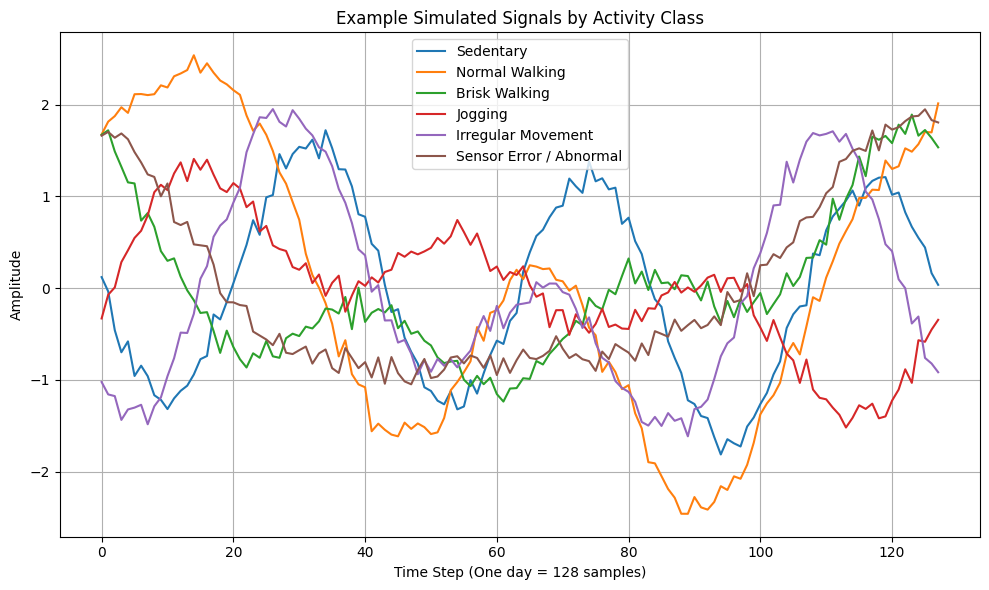

In [ ]:
# Define descriptive names for each activity label
activity_names = {
    0: "Sedentary",
    1: "Normal Walking",
    2: "Brisk Walking",
    3: "Jogging",
    4: "Irregular Movement",
    5: "Sensor Error / Abnormal"
}

# Create a figure with appropriate size
plt.figure(figsize=(10, 6
                    ))

# Loop through each label and plot one sample for each
for label in range(n_labels):
    # Find the first index where this label appears
    sample_idx = np.where(y == label)[0][0]

    # Extract the corresponding signal (a single 128-length time window)
    signal = X[sample_idx]

    # Plot the signal with a descriptive label
    plt.plot(signal, label=activity_names[label])

# Set plot title and axis labels
plt.title("Example Simulated Signals by Activity Class")
plt.xlabel("Time Step (One day = 128 samples)")
plt.ylabel("Amplitude")

# Display legend with activity names
plt.legend()

# Improve spacing and layout
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()


# Prepare PyTorch Dataset and DataLoader

In [ ]:

# Define PyTorch dataset
class SignalDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X[:, np.newaxis, :], dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
train_ds = SignalDataset(X_train, y_train)
test_ds = SignalDataset(X_test, y_test)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64)


# Define a simple 1D-CNN Model

In [ ]:
# Simple 1D CNN model
class Simple1DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool = nn.AdaptiveMaxPool1d(1) #
        self.fc = nn.Linear(32, n_labels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))   # (B, 16, 128)
        x = F.relu(self.bn2(self.conv2(x)))   # (B, 32, 128)
        x = self.pool(x).squeeze(-1)          # (B, 32)
        return self.fc(x)

model = Simple1DCNN().to(device)  # move model to device


# Train the Model

In [ ]:
def train_model(model, train_dl, test_dl, epochs=20):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_loss = []
    test_acc = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in test_dl:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                correct += (preds.argmax(1) == yb).sum().item()
                total += yb.size(0)

        acc = correct / total
        train_loss.append(total_loss / len(train_dl))
        test_acc.append(acc)
        print(f"Epoch {epoch+1}: Loss = {train_loss[-1]:.4f}, Test Acc = {acc:.4f}")

    return train_loss, test_acc

train_loss, test_acc = train_model(model, train_dl, test_dl)


Epoch 1: Loss = 1.4542, Test Acc = 0.4695
Epoch 2: Loss = 1.1374, Test Acc = 0.5633
Epoch 3: Loss = 0.9834, Test Acc = 0.5897
Epoch 4: Loss = 0.9092, Test Acc = 0.6363
Epoch 5: Loss = 0.8713, Test Acc = 0.6380
Epoch 6: Loss = 0.8470, Test Acc = 0.6282
Epoch 7: Loss = 0.8294, Test Acc = 0.6338
Epoch 8: Loss = 0.8100, Test Acc = 0.6493
Epoch 9: Loss = 0.8022, Test Acc = 0.6382
Epoch 10: Loss = 0.7875, Test Acc = 0.6715
Epoch 11: Loss = 0.7760, Test Acc = 0.6663
Epoch 12: Loss = 0.7649, Test Acc = 0.6648
Epoch 13: Loss = 0.7518, Test Acc = 0.6692
Epoch 14: Loss = 0.7429, Test Acc = 0.6838
Epoch 15: Loss = 0.7367, Test Acc = 0.6863
Epoch 16: Loss = 0.7252, Test Acc = 0.7048
Epoch 17: Loss = 0.7208, Test Acc = 0.6902
Epoch 18: Loss = 0.7149, Test Acc = 0.6988
Epoch 19: Loss = 0.7096, Test Acc = 0.7090
Epoch 20: Loss = 0.7007, Test Acc = 0.6998


# TRAINING CURVE VISUALIZATION


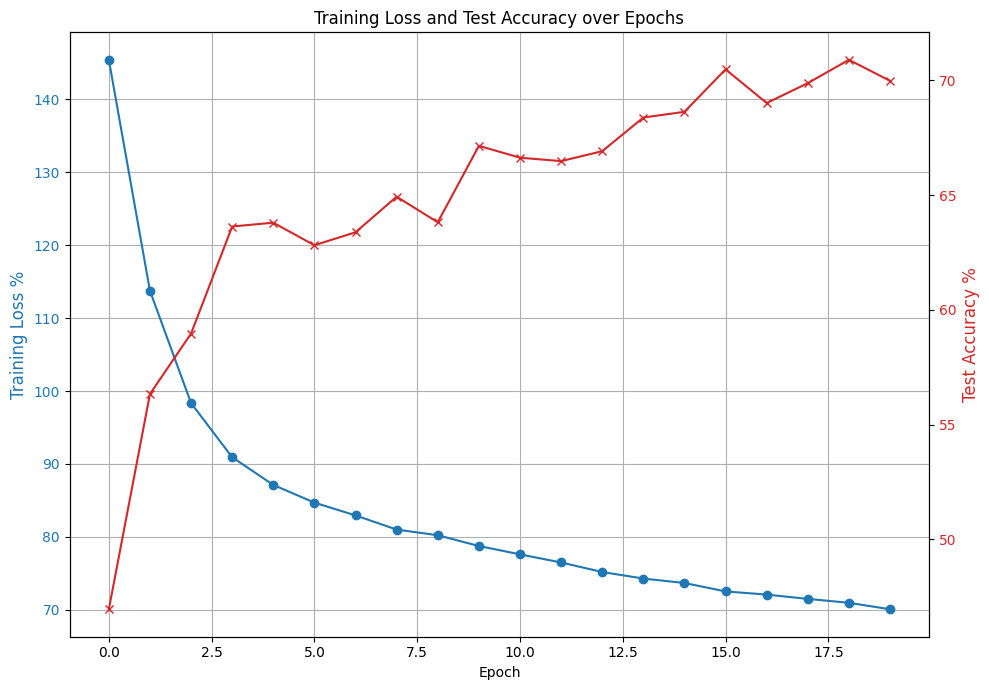

In [ ]:
# Plot loss and accuracy on the same figure using dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 7))

# Left y-axis for training loss
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss %', color=color, fontsize=12)
ax1.plot([loss * 100 for loss in train_loss], color=color, marker='o', label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Right y-axis for test accuracy
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Test Accuracy %', color=color, fontsize=12)
ax2.plot([acc * 100 for acc in test_acc], color=color, marker='x', label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('Training Loss and Test Accuracy over Epochs')
fig.tight_layout()
plt.show()


# Evaluate the Model

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1086
           1       0.60      0.72      0.66       984
           2       0.70      0.65      0.68       924
           3       0.65      0.86      0.74      1044
           4       0.76      0.53      0.62      1032
           5       0.72      0.63      0.67       930

    accuracy                           0.70      6000
   macro avg       0.71      0.70      0.70      6000
weighted avg       0.71      0.70      0.70      6000



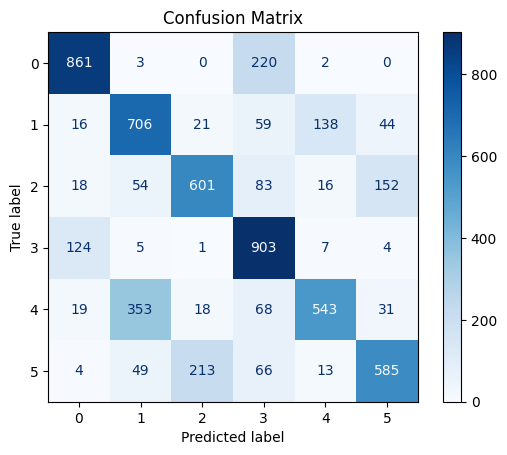

In [ ]:
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        preds = model(xb).cpu()
        y_true.extend(yb.numpy())
        y_pred.extend(preds.argmax(1).numpy())

print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
